## Cluster based on relative peak height

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler

# load data
wdir = '../../data'
df = pd.read_csv(os.path.join(wdir, 'processed/case_data.csv'))

# convert to date format
df['date'] = pd.to_datetime(df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + '1')

# some extra string in place name
df['adm1'] = df['adm1'].str.strip()

# removing Chile, Norway, USA
df = df[~df['country'].isin(['USA', 'Chile', 'Norway'])]
#df = df[df['country'].isin(['Nigeria', 'China', 'Germany', 'Slovenia', 'France', 'Finland'])]


# calculate sum by month and fill in empty dates (where 0)
df = df.groupby(['disease', 'country', 'date']).sum('num_cases', min_count=1).reset_index()
df = df.set_index('date')
df = df.groupby(['disease', 'country']).resample('MS').asfreq(fill_value=0).drop(['country', 'disease'], axis=1).reset_index()
df['month'] = [date.month for date in df.date] # add in new months
df['year'] = [date.year for date in df.date] # and years

df.head()

,disease,country,date,year,month,num_cases
0,Bolivian Hemorrhagic Fever,Bolivia,2010-02-01,2010,2,1.0
1,Bolivian Hemorrhagic Fever,Bolivia,2010-03-01,2010,3,1.0
2,Bolivian Hemorrhagic Fever,Bolivia,2010-04-01,2010,4,0.0
3,Bolivian Hemorrhagic Fever,Bolivia,2010-05-01,2010,5,0.0
4,Bolivian Hemorrhagic Fever,Bolivia,2010-06-01,2010,6,0.0


### Calculate incidence

In [117]:
# using world bank data 
# load and reformat to long data
pop = pd.read_csv(wdir + '/human/worldbank_pop_counts.csv', skiprows=4)
# rename column
pop = pop.rename(columns={'Country Name': 'country'})
# rename slovakia
pop['country'] = pop['country'].str.replace('Slovak Republic', 'Slovakia')
# subset those in dataset
pop = pop[pop['country'].isin(df.country.unique())]
pop = pop.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

pop = pop.melt(id_vars=['country'],
               var_name = 'year',
               value_name = 'population')

pop.year = pop.year.astype(int)
pop.head()

,country,year,population
0,Austria,1960,7047539.0
1,Bolivia,1960,3707515.0
2,Brazil,1960,73092515.0
3,China,1960,667070000.0
4,Germany,1960,72814900.0


In [118]:
# merge with case data and calcultate incidence
df = df.merge(pop, how='left', on=['country', 'year'])
df['incidence'] = df['num_cases']/df['population']*100000
df.head()

,disease,country,date,year,month,num_cases,population,incidence
0,Bolivian Hemorrhagic Fever,Bolivia,2010-02-01,2010,2,1.0,10223270.0,0.009782
1,Bolivian Hemorrhagic Fever,Bolivia,2010-03-01,2010,3,1.0,10223270.0,0.009782
2,Bolivian Hemorrhagic Fever,Bolivia,2010-04-01,2010,4,0.0,10223270.0,0.000000
3,Bolivian Hemorrhagic Fever,Bolivia,2010-05-01,2010,5,0.0,10223270.0,0.000000
4,Bolivian Hemorrhagic Fever,Bolivia,2010-06-01,2010,6,0.0,10223270.0,0.000000


In [119]:
# organize into list of series to work with
mySeries = [group for group in df.groupby(['country', 'disease'])]

# creae a names list
names = ['_'.join(series[0]) for series in mySeries]

len(mySeries)

12

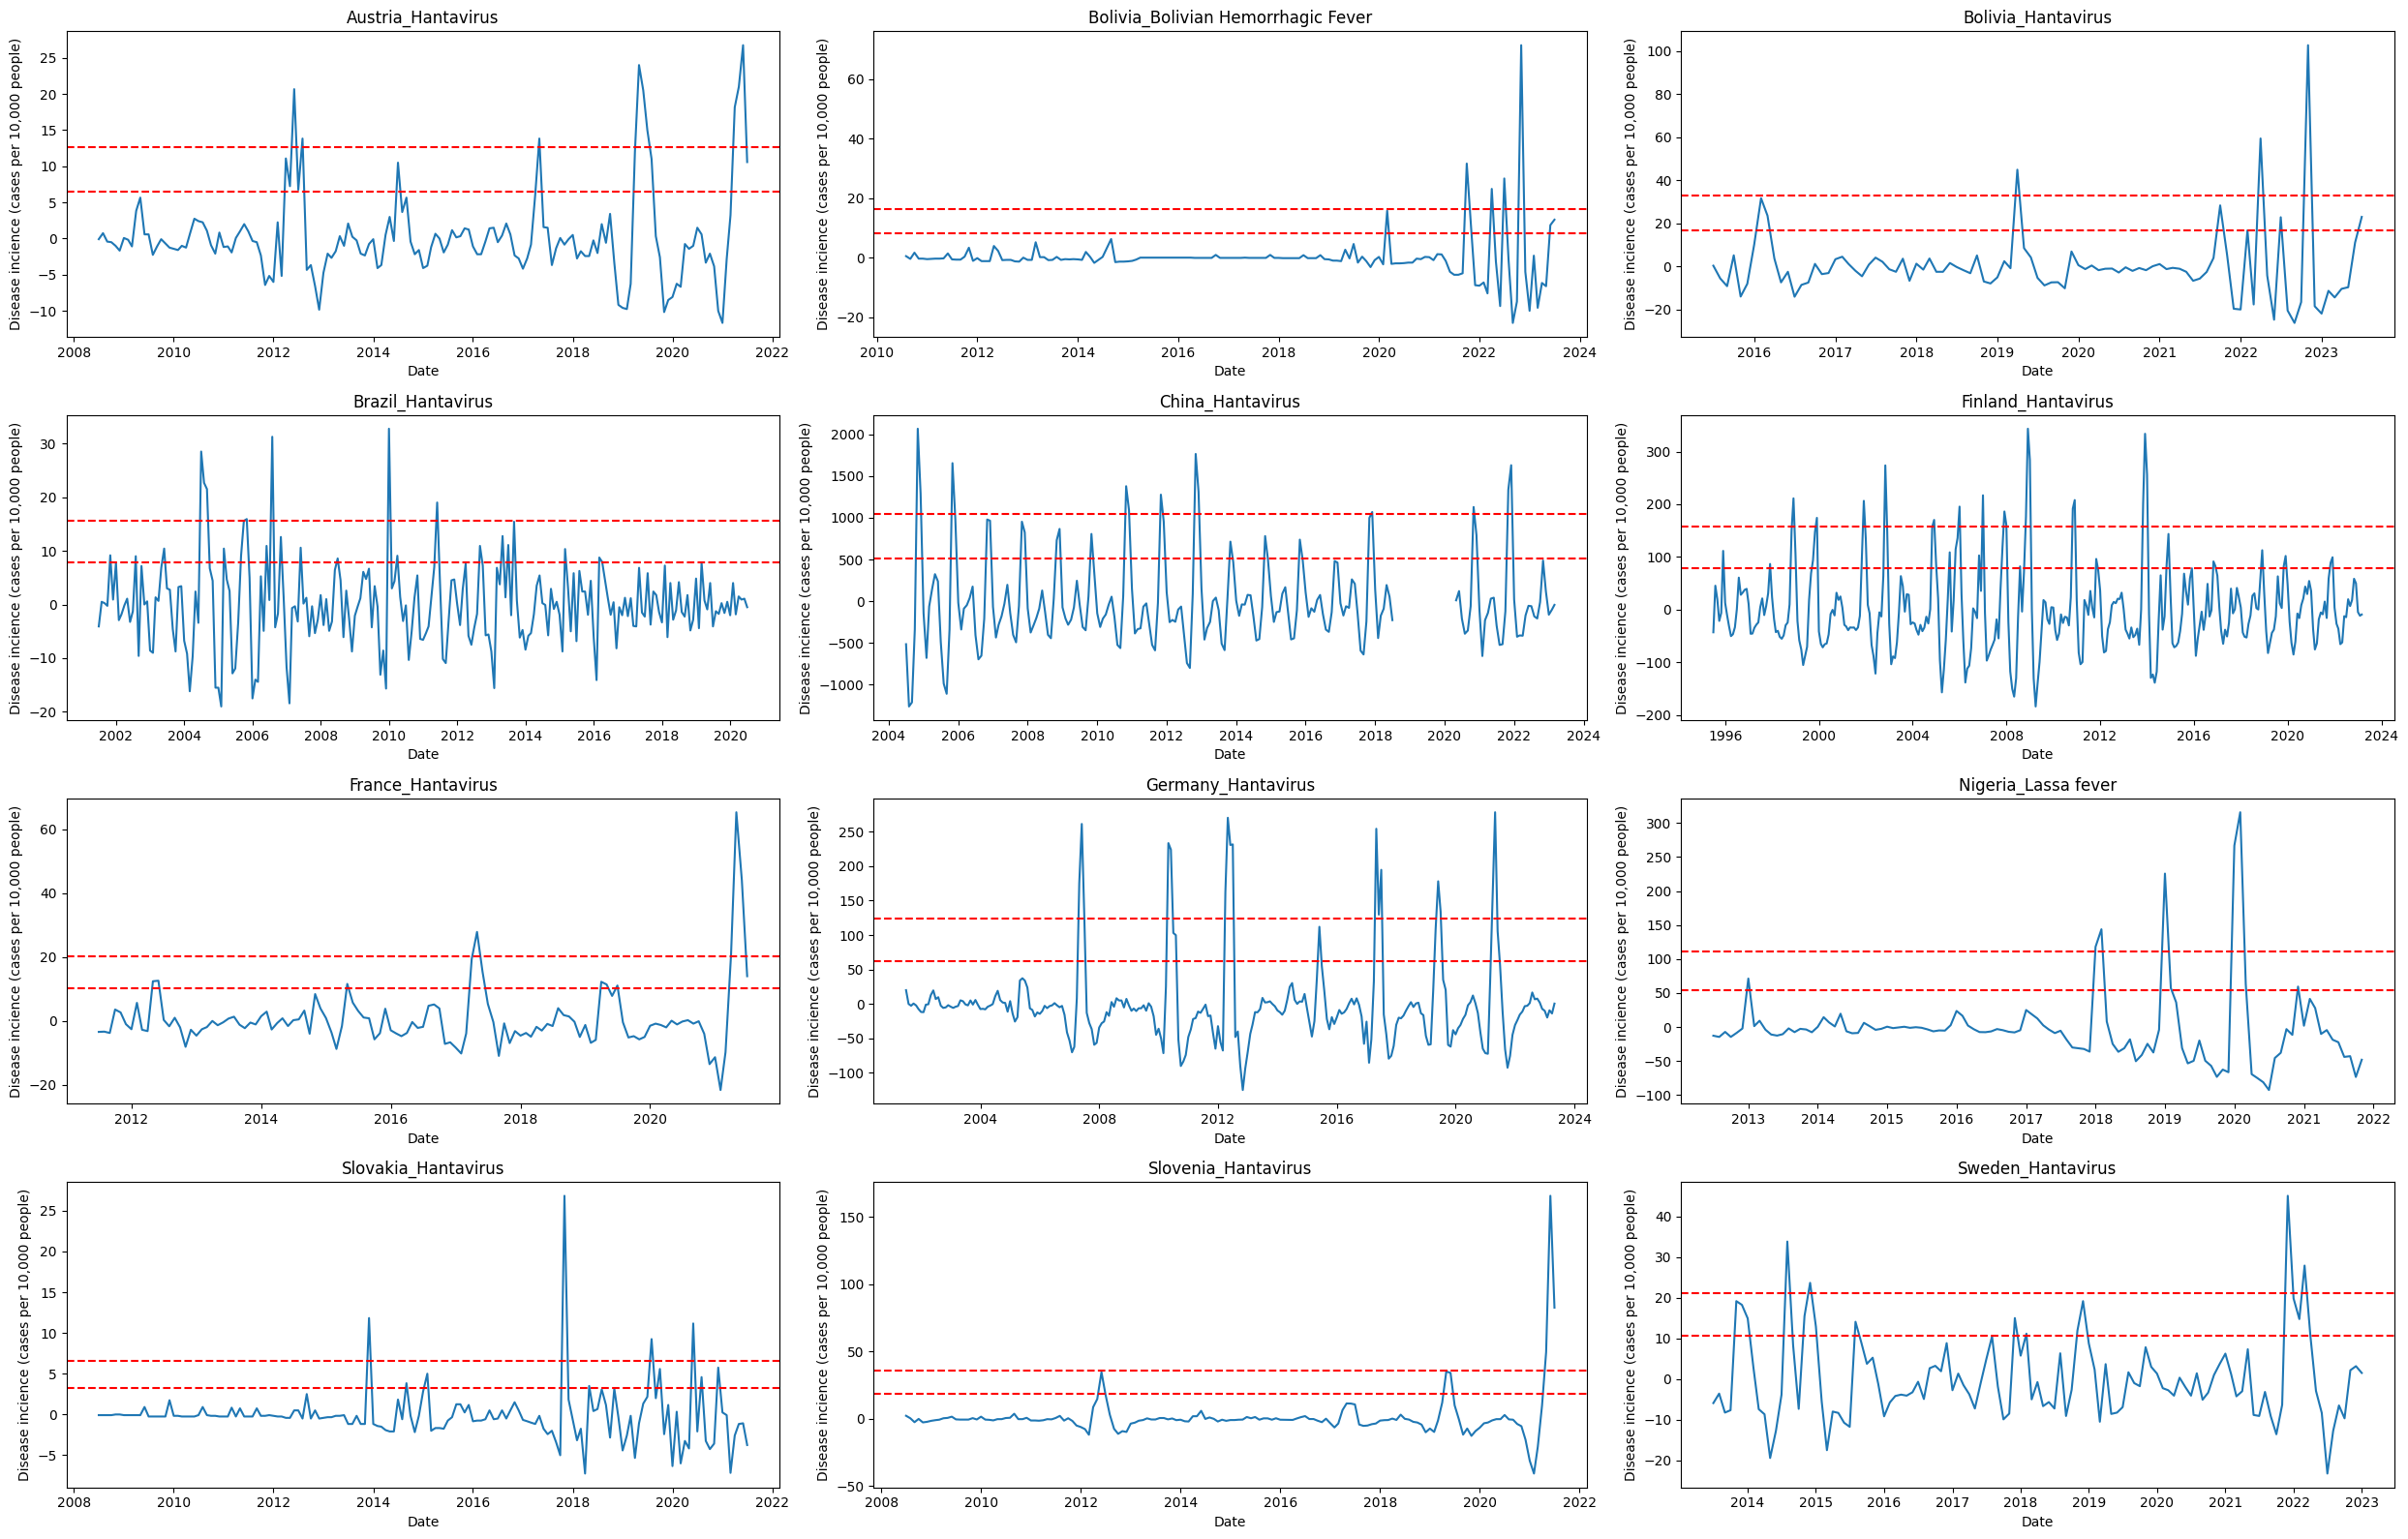

In [129]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import detrend
import math

# 15 disease/country combos so 3 x 5 plots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 16))

# flatten to easily iterate through
axs = axs.flatten()

# create scaler
scaler = MaxAbsScaler()

# peak groups
def catPeaks(x, mn, sd):
    if x < mn+sd or math.isnan(x):
        return 0
    if x < mn+2*sd:
        return 1
    return 2

# peak list
pks = []

df_list = []

# Iterate over the groups and plot on individual subplots
for i, series in enumerate(mySeries):
    series = series[1]
    series = series.set_index('date')
    vals = scaler.fit_transform(series.num_cases.values.reshape(-1,1))
    series['scaled_cases'] = vals
    #series['d'] = detrend(series.num_cases, type='linear')
    #series['d'] = series['d'].diff(12)
    series['d'] = series['num_cases'] - series.num_cases.rolling(window=12,center=True).mean()
    mn = np.mean(series.d)
    sd = np.std(series.d)
    peaks1, _ = find_peaks(series.d)  
    peaks2, _ = find_peaks(series.d, height=mn+2*sd)   
    
    # assign peak group
    series['peak_group'] = series['d'].apply(lambda x: catPeaks(x, mn, sd))
    df_list.append(series)

    # plotting
    ax = axs[i]
    ax.plot(series.d)
    #ax.plot(series.index[peaks1], series.d[peaks1], "x")
    #ax.plot(series.index[peaks2], series.d[peaks2], "o")
    ax.axhline(y=mn+sd, color='r', linestyle='--')
    ax.axhline(y=mn+2*sd, color='r', linestyle='--')
    #ax.set_ylim(0,3)
    ax.set_xlabel('Date')
    #ax.set_yscale("log")
    ax.set_ylabel('Disease incience (cases per 10,000 people)')
    ax.set_title(names[i])
    

plt.tight_layout()
plt.show()

In [121]:
df = pd.concat(df_list)
df = df.reset_index()
df.to_csv('../../output/outbreak_groups.csv')

In [4]:
def check_series(testSet, length=12):
    ids  = [i for i, s in enumerate(testSet) if len(s) > length]
    if len(ids) > 1:
        print('Some series do not have '+ str(length) + ' points.')
        return(ids)
    else:
        print('Series good to go!')
        return

def get_color(label, colormap='tab10'):   
    cmap = plt.get_cmap(colormap)
    color = cmap(label % 10)
    return color

# function for calculating cdf
def cdf(s):
    s = s.sort_index()
    vals = s.num_cases.cumsum() / s.num_cases.sum()
    return(vals)

In [10]:
from tslearn.barycenters import dtw_barycenter_averaging
import matplotlib.pyplot as plt


def plot_series(seriesList, group='year'):
    num_plots = len(seriesList)
    num_rows = (num_plots + 1) // 2 
    num_cols = min(3, num_plots) 
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))
    axs = axs.flatten() 
    for i, series in enumerate(mySeries):
        series = series[1]
        ax = axs[i]
        ax.plot(series.scaled_cases)
        #ax.plot(series.index[peaks], series.num_cases[peaks], "x")
        #ax.set_ylim(0,3)
        ax.set_xlabel('Date')
        #ax.set_yscale("log")
        ax.set_ylabel('Disease incience (cases per 10,000 people)')
        ax.set_title(names[i])



# plotting functions
def plot_clusters(labels, input_data, avg='ba'):
    num_plots = len(set(labels))
    num_rows = (num_plots + 1) // 2  
    num_cols = min(2, num_plots) 
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))
    axs = axs.flatten()

    row=0

    for label in set(labels):    
        cluster = []
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row].plot(input_data[i],c="gray",alpha=0.4)
                cluster.append(input_data[i])
        if len(cluster) > 0:
            if avg == 'ba':
                axs[row].plot(dtw_barycenter_averaging(np.vstack(cluster)),c=get_color(label), linewidth=5)
            if avg == 'euc':
                axs[row].plot(np.average(np.vstack(cluster),axis=0),c=get_color(label), linewidth=5)
        axs[row].set_title("Cluster "+str(label))
        axs[row].set_ylim(0,1)
        axs[row].set_xlim(0,12)
        row+=1
    
    plt.tight_layout()
    plt.show()